In [273]:
import pandas as pd
import numpy as np
import pybedtools
import matplotlib.pyplot as plt

## Import data

In [274]:
chr_sizes_path = "./chromosome_sizes.txt"
cpg_island_path = "./cpgIslandExt.txt"
dna_methyl_path = "./wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed"

In [275]:
chr_sizes_df = pd.read_csv(chr_sizes_path, sep='\t', header=None)
cpg_island_df = pd.read_csv(cpg_island_path, sep='\t', header=None)
dna_methyl_df = pd.read_csv(dna_methyl_path, sep='\t', header=None)

In [276]:
chr_sizes_df.head()

,0,1
0,chr1,249250621
1,chr10,135534747
2,chr11,135006516
3,chr12,133851895
4,chr13,115169878


In [277]:
cpg_island_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,585,chr1,28735,29810,CpG: 116,1075,116,787,21.6,73.2,0.83
1,586,chr1,135124,135563,CpG: 30,439,30,295,13.7,67.2,0.64
2,587,chr1,327790,328229,CpG: 29,439,29,295,13.2,67.2,0.62
3,588,chr1,437151,438164,CpG: 84,1013,84,734,16.6,72.5,0.64
4,588,chr1,449273,450544,CpG: 99,1271,99,777,15.6,61.1,0.84


In [278]:
dna_methyl_df.head()

,0,1,2,3,4,5,6,7,8
0,chr16,53468112,53468162,cg00000029,486,+,53468112,53468162,"128,0,128"
1,chr3,37459206,37459256,cg00000108,916,+,37459206,37459256,"255,127,0"
2,chr3,171916037,171916087,cg00000109,815,+,171916037,171916087,"255,127,0"
3,chr1,91194674,91194724,cg00000165,806,-,91194674,91194724,"255,127,0"
4,chr8,42263294,42263344,cg00000236,843,-,42263294,42263344,"255,127,0"


## Prepare right dataframes

In [279]:
cpg_island_df = cpg_island_df[[1,2,3]].rename({1:'chr_id', 2:'start', 3:'stop'}, axis=1).sort_values(by=['chr_id', 'start'])

In [280]:
dna_methyl_df = dna_methyl_df[[0,1,2]].rename({0:'chr_id', 1:'start', 2:'stop'}, axis=1).sort_values(by=['chr_id', 'start'])

In [281]:
chr_sizes_df = chr_sizes_df.rename({0:'chr_id', 1:'size'}, axis=1).sort_values(by=['chr_id'])

In [282]:
dna_methyl_df['middle'] = dna_methyl_df['start']+((dna_methyl_df['stop'] - dna_methyl_df['start'])/2).astype(int)

In [283]:
dna_methyl_df.groupby('chr_id')['middle'].mean().reset_index().head()

,chr_id,middle
0,chr1,1.012691e+08
1,chr10,7.670546e+07
2,chr11,6.094695e+07
3,chr12,7.372054e+07
4,chr13,7.151071e+07


In [284]:
cpg_island_df.head()

,chr_id,start,stop
0,chr1,28735,29810
1,chr1,135124,135563
2,chr1,327790,328229
3,chr1,437151,438164
4,chr1,449273,450544


In [285]:
chr_sizes_df.head()

,chr_id,size
0,chr1,249250621
1,chr10,135534747
2,chr11,135006516
3,chr12,133851895
4,chr13,115169878


### Only autosomal chromosomes

In [286]:
chr_ids = sorted(cpg_island_df['chr_id'].unique())

In [287]:
autosomal_chr_ids = []

for chr_id in chr_ids:
    try:
        num = int(chr_id[3:])
        if num in range(1,22):
            autosomal_chr_ids.append(chr_id)
    except:
        pass

In [288]:
autosomal_chr_ids

['chr1',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr2',
 'chr20',
 'chr21',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9']

In [289]:
cpg_island_df = cpg_island_df.loc[cpg_island_df.chr_id.isin(autosomal_chr_ids)]

In [290]:
dna_methyl_df = dna_methyl_df.loc[dna_methyl_df.chr_id.isin(autosomal_chr_ids)]

In [291]:
chr_sizes_df = chr_sizes_df.loc[chr_sizes_df.chr_id.isin(autosomal_chr_ids)]
chr_sizes_df.to_csv(chr_sizes_path, header=None, index=False, sep="\t")

## Finding shores, shelves and seas using pybedtools

In [292]:
shore_size = 2000
shelve_size = 2000

### Create cpg.bed

In [293]:
# transformation to pybedtool dataframe
cpg = pybedtools.BedTool.from_dataframe(cpg_island_df).sort()

In [294]:
cpg.head()

chr1	28735	29810
 chr1	135124	135563
 chr1	327790	328229
 chr1	437151	438164
 chr1	449273	450544
 chr1	533219	534114
 chr1	544738	546649
 chr1	713984	714547
 chr1	762416	763445
 chr1	788863	789211
 

In [295]:
cpg.saveas('cpg.bed') 

<BedTool(cpg.bed)>

### Create shore.bed

In [296]:
shores = cpg.flank(g=chr_sizes_path, b=shore_size).sort().merge()
shores.head()

chr1	26735	28735
 chr1	29810	31810
 chr1	133124	135124
 chr1	135563	137563
 chr1	325790	327790
 chr1	328229	330229
 chr1	435151	437151
 chr1	438164	440164
 chr1	447273	449273
 chr1	450544	452544
 

In [297]:
shores.saveas('shores.bed')

<BedTool(shores.bed)>

### Create shelve.bed

In [298]:
shelves = cpg.slop(g=chr_sizes_path, b=shore_size).flank(g=chr_sizes_path, b=shelve_size).sort().merge()
shelves.head()

chr1	24735	26735
 chr1	31810	33810
 chr1	131124	133124
 chr1	137563	139563
 chr1	323790	325790
 chr1	330229	332229
 chr1	433151	435151
 chr1	440164	442164
 chr1	445273	447273
 chr1	452544	454544
 

In [299]:
shelves.saveas('shelves.bed')

<BedTool(shelves.bed)>

### Create sea.bed

In [300]:
seas = cpg.slop(g=chr_sizes_path, b=shore_size+shelve_size).merge().complement(g=chr_sizes_path)
seas.head()

chr1	0	24735
 chr1	33810	131124
 chr1	139563	323790
 chr1	332229	433151
 chr1	442164	445273
 chr1	454544	529219
 chr1	538114	540738
 chr1	550649	709984
 chr1	718547	758416
 chr1	767445	784863
 

In [301]:
seas.saveas('seas.bed')

<BedTool(seas.bed)>

## Prepare plot

In [302]:
dna_methyl_df.head()

,chr_id,start,stop,middle
256612,chr1,15865,15915,15890
259522,chr1,18827,18877,18852
225316,chr1,29407,29457,29432
372828,chr1,29425,29475,29450
8075,chr1,29435,29485,29460


In [303]:
dna_methyl_df.shape

(462368, 4)

In [304]:
dna_methyl_df['middle_stop'] = dna_methyl_df['middle']+1
dna_methyl_df = dna_methyl_df.drop(['start', 'stop'], axis = 1)
dna_methyl_df.head()

,chr_id,middle,middle_stop
256612,chr1,15890,15891
259522,chr1,18852,18853
225316,chr1,29432,29433
372828,chr1,29450,29451
8075,chr1,29460,29461


In [305]:
dna_methyl_df = pybedtools.BedTool.from_dataframe(dna_methyl_df).sort()
dna_methyl_df.saveas('dna_methyl_df.bed')

<BedTool(dna_methyl_df.bed)>

In [306]:
cpg_count = len(dna_methyl_df.intersect(b=cpg,u=True))
shore_count = len(dna_methyl_df.intersect(b=shores,u=True))
shelve_count = len(dna_methyl_df.intersect(b=shelves,u=True))
sea_count = len(dna_methyl_df.intersect(b=seas,u=True))

In [307]:
data = [['Cpg',cpg_count], ['Shore', shore_count], ['Shelve', shelve_count], ['Sea', sea_count]] 
counts = pd.DataFrame(data, columns = ['Region', 'Count']) 
counts['Percentage'] = round(counts['Count']/sum(counts['Count']), 3)
counts

,Region,Count,Percentage
0,Cpg,128887,0.249
1,Shore,137234,0.265
2,Shelve,81965,0.159
3,Sea,168884,0.327


## Draw plot

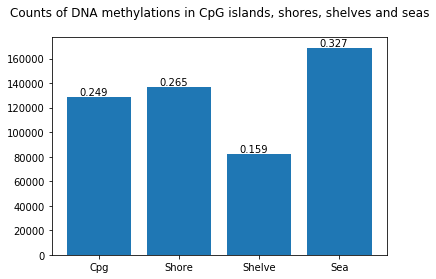

In [311]:
y_pos = np.arange(len(counts['Region']))

plt.bar(y_pos, counts['Count'])

plt.xticks(y_pos, counts['Region'])
xlocs, xlabs = plt.xticks()

for i, h, v in zip(range(len(counts['Percentage'])), counts['Count'], counts['Percentage']):
    plt.text(xlocs[i] - 0.25, h + 1500, str(v))

plt.title("Counts of DNA methylations in CpG islands, shores, shelves and seas\n")
plt.show()